In [1]:
from fastai.vision.all import *
import pandas as pd

In [2]:
chexpert = Path('/storage/archive/CheXpert-v1.0-small')
saved_pkl = Path('../dataset/chexpert-small.pkl')
if saved_pkl.exists():
    dls = torch.load(saved_pkl)
    labels = list(dls.items.iloc[:,6:].columns.values)
else:
    if not chexpert.exists():
        file_extract(chexpert.parent/(chexpert.name +'.zip'))
    train_df = pd.read_csv(chexpert/'train.csv')
    valid_df = pd.read_csv(chexpert/'valid.csv')
    train_df.insert(loc=1, column='Valid', value=False)
    valid_df.insert(loc=1, column='Valid', value=True)
    cat_df = pd.concat([train_df, valid_df]).fillna(0).replace(-1, 0)
    
    labels = list(cat_df.iloc[:,6:].columns.values)
    
    # we resize so that the larger dimension is match and crop 
    # (randomly on the training set, center crop for the validation set)
    # Using batchsize of 128 for trainng and validation
    dls = ImageDataLoaders.from_df(
    df=cat_df, path=chexpert, folder='/storage/archive/',
    label_col=labels, y_block=MultiCategoryBlock(encoded=True, vocab=labels),
    item_tfms=Resize(114), bs=128, val_bs=128)

    torch.save(dls, 'chexpert-small.pkl')

In [3]:
dls.show_batch(max_n=9, figsize=(20,9))

RuntimeError: No CUDA GPUs are available

In [4]:
learn = cnn_learner(dls, densenet121, n_out=len(labels),
                    loss_func=BCEWithLogitsLossFlat(),
                    metrics=RocAucMulti(average='micro'))

# learn.model

# We may be able to load the saved model if available
# learn.load('densenet121-chexpert')

In [5]:
# PyTorch occupies lot of GPU (~15GB) memory and DenseNet121 requires 20MB
torch.cuda.empty_cache()

# `fine_tune` first freezes the body and then updates only head weights for freeze_epochs
# then it unfreezes the body and updates all weights for epochs.
# Internally it uses `fit_one_cycle` for cyclical learning rates:
# Refer: https://iconof.com/1cycle-learning-rate-policy/
# Citation:
#     Smith LN. Cyclical learning rates for training neural networks.
#     In 2017 IEEE winter conference on applications of computer vision
#     (WACV) 2017 Mar 24 (pp. 464-472). IEEE.

learn.fine_tune(epochs=10, freeze_epochs=2)
learn.save('densenet121-chexpert')

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.335027,0.322861,0.852474,06:30
1,0.310942,0.304514,0.869495,05:08


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.299540,0.294475,0.879176,06:06
1,0.293566,0.290305,0.883021,06:10
2,0.288163,0.287075,0.886141,06:01
3,0.284517,0.284485,0.888513,05:59
4,0.276252,0.284724,0.888798,06:00
5,0.267190,0.285698,0.888175,05:59
6,0.255711,0.290839,0.885346,06:00
7,0.245299,0.297560,0.881612,06:00
8,0.235135,0.303401,0.879528,06:04
9,0.229030,0.304465,0.878549,06:00


Path('/storage/archive/CheXpert-v1.0-small/models/densenet121-chexpert.pth')

In [82]:
def get_predictions(preds, vocab, thresh=0.15):
    """Returns predictions >= thresh"""
    pred_labels = []
    pred_tuples = []
    prob_preds = torch.sigmoid(preds[0])
    mask = prob_preds >= thresh
    significant_labels = vocab[mask]
    significant_preds = prob_preds[mask]
    
    for i in range(len(significant_labels)):
        pred_tuples.append((significant_labels[i], significant_preds[i].item()))
    
    pred_tuples.sort(key = lambda x: x[1])
    
    for tup in reversed(pred_tuples):
        pred_labels.append(f'{tup[0]}: {tup[1]:.3f}')
    
    return pred_labels

In [204]:
'''
Multi-class Multi-label Grad-cam algorithm.

Inspired from the multi-class single-label algorithm presented in the following paper:

    Selvaraju, R.R., Cogswell, M., Das, A., Vedantam, R., Parikh, D. and Batra, D., 2017.
    Grad-cam: Visual explanations from deep networks via gradient-based localization.
    In Proceedings of the IEEE international conference on computer vision (pp. 618-626).
'''

def get_last_layer_activations(model, loss_fn, x, classes):
    with hook_output(model[0]) as hook_acts:
        with hook_output(model[0], grad=True) as hook_grads:
            preds = model(x)
            loss_fn(preds[0], classes).backward()
    return hook_acts, hook_grads, preds

def show_activations_heatmap(model, learn, idx, ax1, ax2):
    image, classes = learn.dls.valid_ds[idx]
    
    # Transform the image as per the dataloader
    # split_idx=1 for validation and test set (center crop)
    image = dls.after_item[0](image, split_idx=1)
    true_labels = learn.dls.vocab[classes == 1]
    x, = first(dls.test_dl([image]))
    classes = classes.cuda()
    x = x.cuda()

    hook_acts, hook_grads, preds = get_last_layer_activations(model, learn.loss_func, x, classes)
    acts = hook_acts.stored[0].cpu()
    grads = hook_grads.stored[0][0].cpu()
    grads_chan = grads.mean(1).mean(1)
    mult = F.relu((acts * grads_chan[...,None,None]).mean(0))
        
    pred_labels = get_predictions(preds, learn.dls.vocab, thresh=0.15)
    
    image.show(ax1, extent=(0,144,144,0))
    image.show(ax2, extent=(0,144,144,0))
    
    ax2.imshow(mult, alpha=0.6, extent=(0,144,144,0),
              interpolation='bilinear', cmap='magma')
    
    title = f'True: {true_labels}\n    Pred: {pred_labels}\n'
    
    return title
    
def plot_cam(model, learn):
    val_size = len(dls.valid_ds)

    fig, ax = plt.subplots(3, 3*2)
    fig.set_size_inches(12,6)
    
    title = ''

    for i in range(3):
        for j in range(0, 6, 2):
            idx = random.randint(0, val_size)
            count = 3*i + int(j/2)
            image_id = chr(ord('A') + count)
            sub_title = show_activations_heatmap(model, learn, idx, ax[i, j], ax[i, j+1])
            ax[i, j].set_title(f'{image_id}')
            ax[i, j+1].set_title(f'{image_id}-CAM')
            title += f'{image_id}. {sub_title}\n'
    
    fig.text(0.15, -0.65, title)

    plt.show()

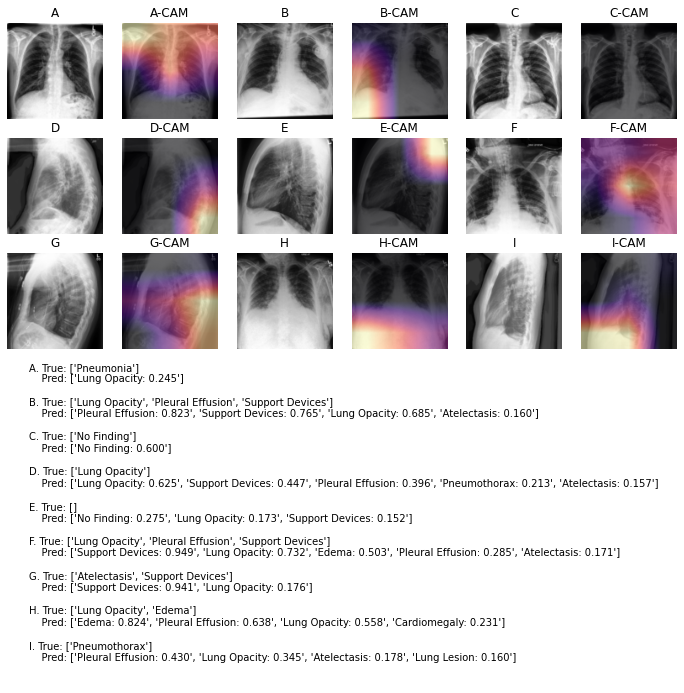

In [205]:
model = learn.model.eval()
model = model.cuda()
plot_cam(model, learn)